#### JUG: JAX-based pulsar timing playground (no PINT)

This notebook sketches a PINT/Tempo2-free pipeline: parse `.par`/`.tim`, build a minimal timing model, and compute residuals in JAX. Currently supports spin (F0/F1/F2) and DM delay; barycentric conversion and binary/relativistic terms are left to fill in.


**Scope and caveats**
- Assumes TOAs are already at (or close to) the Solar System barycenter; clock/site/SSB corrections are not implemented.
- `.tim` parsing here is minimal (MJD, frequency MHz, observatory tag); extend as needed.
- Delays implemented: spin phase (F0/F1/F2), cold-plasma DM delay.
- JAX is used for fast residual computation/JIT; everything else is plain Python.


In [966]:
import jax, jax.numpy as jnp
jax.config.update('jax_enable_x64', True)  # timing precision needs float64
import numpy as np
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Any, List
import os
import shutil
import math
import subprocess, shlex
from astropy.time import Time
from astropy.utils import iers
from astropy.coordinates import EarthLocation, Angle, solar_system_ephemeris, get_body_barycentric_posvel, SkyCoord, Distance
from astropy.constants import GM_sun, GM_jup, G, M_jup
import astropy.units as u
from jplephem.spk import SPK
import matplotlib.pyplot as plt

# Allow forcing CPU-only via env var (export JAX_PLATFORM_NAME=cpu)
if os.environ.get('JAX_PLATFORM_NAME', '') == 'cpu':
    jax.config.update('jax_platform_name', 'cpu')

C_M_S = 299792458.0

SECS_PER_DAY = 86400.0
K_DM_SEC = 4.148808e3  # MHz^2 pc^-1 cm^3 s (cold plasma dispersion)

print('JAX version:', jax.__version__)
jax.devices()


JAX version: 0.8.1


[CudaDevice(id=0)]

In [967]:
# --- File parsers (minimal) ---

def parse_par(path: Path) -> Dict[str, Any]:
    params: Dict[str, Any] = {}
    for raw in path.read_text().splitlines():
        line = raw.strip()
        if not line or line.startswith('C') or line.startswith('#'):
            continue
        parts = line.split()
        key = parts[0].upper()
        if len(parts) < 2:
            continue
        val_token = parts[1]
        try:
            val = float(val_token)
        except ValueError:
            val = val_token
        params[key] = val
    return params

def parse_tim(path: Path) -> List[Dict[str, Any]]:
    toas = []
    fmt = None
    for raw in path.read_text().splitlines():
        line = raw.strip()
        if not line:
            continue
        if line.startswith('C') or line.startswith('c'):
            # tempo2 comment/ignore
            continue
        upper = line.upper()
        if upper.startswith('FORMAT'):
            try:
                fmt = int(upper.split()[1])
            except Exception:
                fmt = 1
            continue
        if upper.startswith('MODE'):
            continue
        parts = line.split()
        if not parts:
            continue
        if fmt == 1 and len(parts) >= 5:
            # FORMAT 1: filename, freq(MHz), MJD, err(us), telescope code
            filename = parts[0]
            freq_mhz = float(parts[1])
            mjd = float(parts[2])
            toa_err_us = float(parts[3])
            obs = parts[4]
        else:
            # Fallback: try old parsing heuristics
            if parts[0][0].isdigit():
                mjd = float(parts[0])
                freq_mhz = float(parts[1]) if len(parts) > 1 else np.nan
                obs = parts[2] if len(parts) > 2 else ''
                toa_err_us = float(parts[3]) if len(parts) > 3 else np.nan
            else:
                obs = parts[0]
                mjd = float(parts[1])
                freq_mhz = float(parts[2]) if len(parts) > 2 else np.nan
                toa_err_us = float(parts[3]) if len(parts) > 3 else np.nan
        toas.append({'mjd': mjd, 'freq_mhz': freq_mhz, 'obs': obs, 'err_us': toa_err_us, 'raw': line})
    return toas


In [968]:

# --- Load files ---
psrname="J1909-3744"
par_path = Path('/home/mattm/projects/MPTA/partim/production/fifth_pass/{0}.par'.format(psrname))
tim_path = Path('/home/mattm/projects/MPTA/partim/production/fifth_pass/{0}.tim'.format(psrname))

if not par_path.exists():
    raise FileNotFoundError(f'Update par_path; not found: {par_path}')
if not tim_path.exists():
    raise FileNotFoundError(f'Update tim_path; not found: {tim_path}')

par_params = parse_par(par_path)
tim_entries = parse_tim(tim_path)

raw_mjd = np.array([t['mjd'] for t in tim_entries], dtype=np.float64)
obs_codes = np.array([t['obs'] for t in tim_entries])
freq_mhz = np.array([t['freq_mhz'] for t in tim_entries], dtype=np.float64)

# t_mjd will be clock-corrected after clock files are loaded
t_mjd = raw_mjd.copy()

print('Loaded', len(t_mjd), 'TOAs (raw; clock correction applied later)')
list(par_params.items())[:8]


Loaded 10408 TOAs (raw; clock correction applied later)


[('PSRJ', 'J1909-3744'),
 ('RAJ', '19:09:47.4247518'),
 ('DECJ', '-37:44:14.90940'),
 ('F0', 339.31568665788393),
 ('F1', -1.6147500186152084e-15),
 ('PEPOCH', 59018.0),
 ('POSEPOCH', 59018.0),
 ('DMEPOCH', 59000.0)]

In [969]:
# --- Observatory positions and JPL ephemeris ---
obs_table_path = Path('data/observatory/observatories.dat')
alias_path = Path('data/observatory/tempo.aliases')
ephem_kernel_path = Path('data/ephemeris/de440s.bsp')

for p in [obs_table_path, alias_path, ephem_kernel_path]:
    if not p.exists():
        raise FileNotFoundError(f'Missing required data file: {p}')

def load_observatory_positions(path: Path):
    mapping = {}
    for raw in path.read_text().splitlines():
        line = raw.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split()
        if len(parts) < 4:
            continue
        try:
            x, y, z = map(float, parts[:3])
        except ValueError:
            continue
        aliases = [tok.strip() for tok in parts[3:] if tok.strip()]
        for name in aliases:
            mapping[name.lower()] = (x, y, z)
    return mapping

def load_aliases(path: Path):
    alias_map = {}
    for raw in path.read_text().splitlines():
        line = raw.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split()
        base = parts[0].lower()
        for tok in parts:
            alias_map[tok.lower()] = base
    return alias_map

obs_positions = load_observatory_positions(obs_table_path)
alias_map = load_aliases(alias_path)

def resolve_obs(code: str) -> str:
    key = alias_map.get(code.lower(), code.lower())
    if key not in obs_positions:
        raise KeyError(f'Unknown observatory code: {code}')
    return key

ephem_kernel = SPK.open(ephem_kernel_path)
emb_segment = ephem_kernel[0, 3]  # EMB wrt SSB
geo_segment = ephem_kernel[3, 399]  # geocenter wrt EMB
len(obs_positions), list(obs_positions.items())[:3]


(226,
 [('gbt', (882589.289, -4924872.368, 3943729.418)),
  ('narrabri', (-4752329.7, 2790505.934, -3200483.747)),
  ('atca', (-4752329.7, 2790505.934, -3200483.747))])

In [970]:
# --- Clock/EOP setup ---
iers_conf = iers.conf
iers_conf.auto_download = False
iers_conf.iers_auto_url = ''
iers_conf.auto_max_age = None
iers_conf.iers_degraded_accuracy = 'ignore'
iers_conf.remote_timeout = 0
# Load local EOP if needed
iers_path = Path('data/earth/eopc04_IAU2000.62-now')
if iers_path.exists():
    try:
        iers_a = iers.IERS_A.open(iers_path)
        iers.conf.auto_max_age = None
    except Exception:
        iers_a = None
else:
    iers_a = None

clock_dir = Path('data/clock')
clock_files = list(clock_dir.glob('*.clk')) if clock_dir.exists() else []

def read_clock_offsets(clock_files):
    offsets = {}
    for cf in clock_files:
        for ln in cf.read_text().splitlines():
            if not ln or ln.startswith('#'):
                continue
            parts = ln.split()
            if len(parts) < 2:
                continue
            try:
                mjd = float(parts[0]); offset = float(parts[1])
                offsets.setdefault(cf.name, []).append((mjd, offset))
            except Exception:
                continue
    return offsets

clock_offsets = read_clock_offsets(clock_files)


# Clock correction graph (tempo2-like chaining using filenames such as mk2utc.clk, utc2tai.clk, tai2tt_*.clk)
from bisect import bisect_left

def _load_clock_edges(clock_dir: Path):
    edges = {}
    for cf in clock_dir.glob('*.clk'):
        name = cf.stem.lower()
        if '2' not in name:
            continue
        src, dst = name.split('2', 1)
        try:
            data = []
            for ln in cf.read_text().splitlines():
                if not ln or ln.startswith('#'):
                    continue
                parts = ln.split()
                if len(parts) < 2:
                    continue
                mjd = float(parts[0]); off = float(parts[1])
                data.append((mjd, off))
            if not data:
                continue
            data.sort()
            edges.setdefault(src, []).append({'dst': dst, 'mjd': [d[0] for d in data], 'off': [d[1] for d in data]})
        except Exception:
            continue
    return edges

def _interp_offset(series, mjd):
    mjds = series['mjd']; offs = series['off']
    idx = bisect_left(mjds, mjd)
    if idx == 0:
        return offs[0]
    if idx >= len(mjds):
        return offs[-1]
    t0, t1 = mjds[idx-1], mjds[idx]
    o0, o1 = offs[idx-1], offs[idx]
    w = (mjd - t0) / (t1 - t0) if t1 != t0 else 0.0
    return o0 + w * (o1 - o0)

def _choose_tai2tt(edges):
    candidates = edges.get('tai', [])
    # pick the most recent bipm file if available
    best = None; best_year = -1
    for c in candidates:
        dst = c['dst']
        if dst.startswith('tt'):
            try:
                year = int(dst.split('_')[-1].replace('bipm','').replace('.clk','')[:4])
            except Exception:
                year = -1
            if year > best_year:
                best_year = year; best = c
    return best or (candidates[0] if candidates else None)

def build_clock_graph(clock_dir: Path):
    edges = _load_clock_edges(clock_dir)
    # ensure tai->tt edge selection
    return edges, _choose_tai2tt(edges)

clock_edges, tai2tt_edge = build_clock_graph(clock_dir)

# Resolve site code to clock source names (include aliases)
def _clock_sources_for_obs(code: str):
    out = []
    base = alias_map.get(code.lower(), code.lower())
    # include all alias tokens that map to the same base (tempo2-style alias resolution)
    alias_tokens = [k for k, v in alias_map.items() if v == base]
    out.extend(alias_tokens)
    out.append(base)
    out.append(base[:2])
    out.append(base[:3])
    out.append(code.lower())
    return list(dict.fromkeys([s for s in out if s]))

def clock_correction_seconds(mjd_utc: float, obs_code: str):
    # walk chain src->...->utc->tai->tt; offsets are added to get to next scale
    src_candidates = _clock_sources_for_obs(obs_code)
    total = 0.0
    visited = set()
    for src in src_candidates:
        cur = src
        total = 0.0
        visited.clear()
        while True:
            if cur in visited:
                break
            visited.add(cur)
            edges = clock_edges.get(cur, [])
            if not edges:
                break
            # prefer utc, gps, tai, tt in that order
            edges_sorted = sorted(edges, key=lambda e: ['utc','gps','tai','tt'].index(e['dst']) if e['dst'] in ['utc','gps','tai','tt'] else 99)
            edge = edges_sorted[0]
            off = _interp_offset(edge, mjd_utc)
            total += off
            cur = edge['dst']
            if cur in ('tt', 'tai') and (cur=='tt' or tai2tt_edge):
                if cur=='tai' and tai2tt_edge:
                    total += _interp_offset(tai2tt_edge, mjd_utc)
                return total
            if cur in ('utc','gps'):
                continue
        # try next candidate source
    return 0.0


# Apply clock corrections to TOAs
if 'raw_mjd' in globals():
    clock_sec = np.array([clock_correction_seconds(mjd, obs) for mjd, obs in zip(raw_mjd, obs_codes)])
    t_mjd = raw_mjd + clock_sec / SECS_PER_DAY
    print('Applied clock corrections (s):', float(np.mean(clock_sec)), '±', float(np.std(clock_sec)))


Applied clock corrections (s): 69.18402801869388 ± 1.3888912578847496e-07


In [971]:
# --- Timing model container ---
@dataclass
class SpinDMModel:
    f0: float  # Hz
    f1: float = 0.0  # Hz/s
    f2: float = 0.0  # Hz/s^2
    dm: float = 0.0  # pc / cm^3 (zeroth DM term)
    dm1: float = 0.0  # pc / cm^3 / yr (legacy)
    dm2: float = 0.0  # pc / cm^3 / yr^2 (legacy)
    dm_coeffs: Any = None  # array of DM derivatives (DM, DM1, DM2, ...)
    dm_factorials: Any = None  # factorial denominators
    dm_epoch_mjd: float = 0.0  # epoch for DM derivatives (MJD)
    tref_mjd: float = 0.0  # reference epoch (MJD)
    phase_ref_mjd: float = 0.0  # reference phase epoch (MJD)
    phase_offset_cycles: float = 0.0  # integer cycle offset to enforce TZR anchor

import jax.tree_util as jtu
jtu.register_pytree_node(
    SpinDMModel,
    lambda s: ((s.f0, s.f1, s.f2, s.dm_coeffs, s.dm_factorials, s.dm_epoch_mjd, s.tref_mjd, s.phase_ref_mjd, s.phase_offset_cycles), None),
    lambda _, vals: SpinDMModel(*vals),
)

def build_model(par: Dict[str, Any], t_ref_guess: float) -> SpinDMModel:
    f0 = float(par.get('F0', np.nan))
    f1 = float(par.get('F1', 0.0))
    f2 = float(par.get('F2', 0.0))
    dm_epoch = float(par.get('DMEPOCH', t_ref_guess))
    dm_coeffs = []
    k = 0
    while True:
        key = 'DM' if k == 0 else f'DM{k}'
        if key in par:
            dm_coeffs.append(float(par[key]))
            k += 1
        else:
            break
    if not dm_coeffs:
        dm_coeffs = [0.0]
    dm_factorials = [math.factorial(i) for i in range(len(dm_coeffs))]
    dm_coeffs_arr = np.array(dm_coeffs, dtype=np.float64)
    dm_factorials_arr = np.array(dm_factorials, dtype=np.float64)
    tref = float(par.get('PEPOCH', par.get('POSEPOCH', t_ref_guess)))
    phase_ref = float(par.get('TZRMJD', tref))
    dm0 = dm_coeffs_arr[0] if dm_coeffs_arr.size > 0 else 0.0
    dm1 = dm_coeffs_arr[1] if dm_coeffs_arr.size > 1 else 0.0
    dm2 = dm_coeffs_arr[2] if dm_coeffs_arr.size > 2 else 0.0
    return SpinDMModel(
        f0=f0, f1=f1, f2=f2,
        dm=dm0, dm1=dm1, dm2=dm2,
        dm_coeffs=dm_coeffs_arr, dm_factorials=dm_factorials_arr,
        dm_epoch_mjd=dm_epoch, tref_mjd=tref, phase_ref_mjd=phase_ref,
        phase_offset_cycles=0.0,
    )


# TCB scaling factor (IAU L_B)
L_B = 1.550519768e-8
model = build_model(par_params, t_ref_guess=float(np.mean(t_mjd)))
model


SpinDMModel(f0=339.31568665788393, f1=-1.6147500186152084e-15, f2=0.0, dm=np.float64(10.390712063001434), dm1=np.float64(-1.6514137754873593e-06), dm2=np.float64(-5.2082301213692484e-05), dm_coeffs=array([ 1.03907121e+01, -1.65141378e-06, -5.20823012e-05]), dm_factorials=array([1., 1., 2.]), dm_epoch_mjd=59000.0, tref_mjd=59018.0, phase_ref_mjd=59679.248061951184, phase_offset_cycles=0.0)

In [972]:

# --- Sky position and barycentric delay ---

def parse_angle(val, unit):
    if val is None:
        raise ValueError('Missing angle value')
    if isinstance(val, str):
        try:
            return Angle(val, unit=unit).to_value(u.rad)
        except Exception:
            pass
    try:
        return Angle(float(val), unit=unit).to_value(u.rad)
    except Exception as exc:
        raise ValueError(f'Could not parse angle {val}') from exc

def sky_unit_vector(ra_rad: float, dec_rad: float):
    cosd = np.cos(dec_rad)
    return np.array([cosd * np.cos(ra_rad), cosd * np.sin(ra_rad), np.sin(dec_rad)])

def barycentric_delay_seconds(
    mjd_utc: np.ndarray,
    obs_codes: np.ndarray,
    ra_rad: float,
    dec_rad: float,
    pm_ra_masyr: float = 0.0,
    pm_dec_masyr: float = 0.0,
    px_mas: float = 0.0,
    pm_epoch: float = None,
    t_utc: Time = None,
    t_tdb: Time = None,
    loc_cache=None,
    emb_segment=None,
    geo_segment=None,
):
    t = t_utc if t_utc is not None else Time(mjd_utc, format='mjd', scale='utc')
    tdb = t_tdb if t_tdb is not None else t.tdb
    delays = np.zeros_like(mjd_utc, dtype=np.float64)
    loc_cache = {} if loc_cache is None else loc_cache
    unique_codes = np.unique(obs_codes)
    # Reference coord at PM epoch
    coord_kwargs = {
        'ra': ra_rad * u.rad,
        'dec': dec_rad * u.rad,
        'pm_ra_cosdec': pm_ra_masyr * u.mas / u.yr,
        'pm_dec': pm_dec_masyr * u.mas / u.yr,
        'frame': 'icrs',
        'obstime': Time(pm_epoch, format='mjd', scale='tdb') if pm_epoch is not None else Time(np.mean(tdb.mjd), format='mjd', scale='tdb'),
    }
    if px_mas != 0.0:
        coord_kwargs['distance'] = Distance(parallax=px_mas * u.mas)
    base_coord = SkyCoord(**coord_kwargs)
    # Earth barycentric position from jplephem (ephem_kernel already open)
    emb_seg = ephem_kernel[0, 3]
    geo_seg = ephem_kernel[3, 399]
    emb_pos_km = emb_seg.compute(tdb.jd)
    geo_from_emb_km = geo_seg.compute(tdb.jd)
    earth_pos_m = (emb_pos_km + geo_from_emb_km).T * 1000.0
    for code in unique_codes:
        key = resolve_obs(code)
        loc = loc_cache.get(key)
        if loc is None:
            x, y, z = obs_positions[key]
            loc = loc_cache.setdefault(key, EarthLocation.from_geocentric(x, y, z, unit=u.m))
        mask = obs_codes == code
        t_chunk = t if len(unique_codes) == 1 else t[mask]
        # apply space motion to chunk times
        target = base_coord.apply_space_motion(new_obstime=t_chunk)
        n = target.cartesian.get_xyz().value
        n = n / np.linalg.norm(n, axis=0, keepdims=True)
        if n.shape[1] != len(t_chunk):
            n = np.repeat(n, len(t_chunk), axis=1)
        n = n.T  # shape (N,3)
        pos, vel = loc.get_gcrs_posvel(t_chunk)
        site_pos = np.stack([pos.x.to_value(u.m), pos.y.to_value(u.m), pos.z.to_value(u.m)], axis=1)
        r_ssb_site = earth_pos_m + site_pos
        delay_vec = np.sum(r_ssb_site * n, axis=1) / C_M_S
        if len(unique_codes) == 1:
            delays[:] = delay_vec
        else:
            delays[mask] = delay_vec
    return delays


In [973]:
# --- Astrometry helpers (PM/PX/aberration) ---
AU_M = 149597870700.0
def sky_unit_vector_pm_px(ra0_rad, dec0_rad, pm_ra_masyr=0.0, pm_dec_masyr=0.0, px_mas=0.0, t_epoch_mjd=None, t_mjd=None, t_bary_vec=None):
    pm_ra_radyr = np.deg2rad(pm_ra_masyr / (3600.0 * 1000.0))
    pm_dec_radyr = np.deg2rad(pm_dec_masyr / (3600.0 * 1000.0))
    dt_years = 0.0 if t_mjd is None or t_epoch_mjd is None else (t_mjd - t_epoch_mjd) / 365.25
    ra = ra0_rad + pm_ra_radyr * dt_years / np.cos(dec0_rad)
    dec = dec0_rad + pm_dec_radyr * dt_years
    ra = np.atleast_1d(ra)
    dec = np.atleast_1d(dec)
    n = np.stack([np.cos(dec) * np.cos(ra), np.cos(dec) * np.sin(ra), np.sin(dec)], axis=-1)
    if px_mas != 0.0 and t_bary_vec is not None:
        px_rad = np.deg2rad(px_mas / (3600.0 * 1000.0))
        tvec = np.atleast_2d(t_bary_vec)
        if tvec.shape[0] != n.shape[0]:
            tvec = np.repeat(tvec, n.shape[0], axis=0)
        n = n + px_rad * tvec / AU_M
        n = n / np.linalg.norm(n, axis=-1, keepdims=True)
    return n

def aberration_correct(n_hat, vel_vec_mps):
    beta = vel_vec_mps / C_M_S
    beta2 = np.sum(beta**2, axis=-1, keepdims=True)
    gamma = 1.0 / np.sqrt(1.0 - beta2)
    dot = np.sum(n_hat * beta, axis=-1, keepdims=True)
    n_prime = n_hat + ((gamma-1.0)/beta2) * dot * beta - gamma * beta
    n_prime = n_prime / np.linalg.norm(n_prime, axis=-1, keepdims=True)
    return n_prime

def finite_diff_velocity(tdb_jd: np.ndarray, emb_seg, geo_seg, eps_days=1e-5):
    tdb_jd = np.atleast_1d(tdb_jd)
    t_plus = tdb_jd + eps_days
    t_minus = tdb_jd - eps_days
    emb_plus = emb_seg.compute(t_plus)
    emb_minus = emb_seg.compute(t_minus)
    geo_plus = geo_seg.compute(t_plus)
    geo_minus = geo_seg.compute(t_minus)
    pos_plus = (emb_plus + geo_plus)
    pos_minus = (emb_minus + geo_minus)
    vel_km_per_day = (pos_plus - pos_minus) / (2 * eps_days)
    vel_mps = vel_km_per_day.T * 1000.0 / SECS_PER_DAY
    return vel_mps


In [974]:
# --- Einstein and solar-system Shapiro delays ---
MU_SUN = GM_sun.value
try:
    MU_JUP = GM_jup.value
except Exception:
    MU_JUP = float((G * M_jup).to(u.m**3 / u.s**2).value)

shapiro_bodies = {
    'sun': {'mu': MU_SUN, 'segment': (0, 10)},
    'mercury': {'mu': 2.2032e13, 'segment': (0, 1)},
    'venus': {'mu': 3.24859e14, 'segment': (0, 2)},
    'mars': {'mu': 4.282837e13, 'segment': (0, 4)},
    'jupiter': {'mu': MU_JUP, 'segment': (0, 5)},
    'saturn': {'mu': 3.7931187e16, 'segment': (0, 6)},
    'uranus': {'mu': 5.793939e15, 'segment': (0, 7)},
    'neptune': {'mu': 6.836529e15, 'segment': (0, 8)},
}

def shapiro_solar_system_delay(mjd_utc: np.ndarray, obs_codes: np.ndarray, ra_rad: float, dec_rad: float, t_utc: Time = None, t_tdb: Time = None, loc_cache=None, emb_segment=None, geo_segment=None):
    t = t_utc if t_utc is not None else Time(mjd_utc, format='mjd', scale='utc')
    tdb = t_tdb if t_tdb is not None else t.tdb
    n_hat = sky_unit_vector(ra_rad, dec_rad)
    n_hat = np.atleast_2d(n_hat) if n_hat.ndim==1 else n_hat
    delays = np.zeros_like(mjd_utc, dtype=np.float64)
    loc_cache = {} if loc_cache is None else loc_cache
    emb_seg = emb_segment if emb_segment is not None else ephem_kernel[0, 3]
    geo_seg = geo_segment if geo_segment is not None else ephem_kernel[3, 399]
    for code in np.unique(obs_codes):
        key = resolve_obs(code)
        loc = loc_cache.get(key)
        if loc is None:
            x, y, z = obs_positions[key]
            loc = loc_cache.setdefault(key, EarthLocation.from_geocentric(x, y, z, unit=u.m))
        mask = obs_codes == code
        t_chunk = t[mask]
        tdb_chunk = tdb[mask]
        pos, vel = loc.get_gcrs_posvel(t_chunk)
        site_pos = np.stack([pos.x.to_value(u.m), pos.y.to_value(u.m), pos.z.to_value(u.m)], axis=1)
        emb_pos_km = emb_seg.compute(tdb_chunk.jd)
        geo_from_emb_km = geo_seg.compute(tdb_chunk.jd)
        earth_pos_m = (emb_pos_km + geo_from_emb_km).T * 1000.0
        r_site = earth_pos_m + site_pos
        vel_mps = finite_diff_velocity(tdb_chunk.jd, emb_seg, geo_seg)
        n_hat_ab = aberration_correct(n_hat, vel_mps)
        delay_chunk = np.zeros(len(t_chunk), dtype=np.float64)
        for body in shapiro_bodies.values():
            seg = ephem_kernel[body['segment']]
            r_body_m = seg.compute(tdb_chunk.jd).T * 1000.0
            r_vec = r_body_m - r_site
            r_norm = np.linalg.norm(r_vec, axis=1)
            proj = np.einsum('ij,ij->i', r_vec, n_hat_ab)
            arg = (r_norm + proj) / r_norm
            delay_chunk += -2.0 * body['mu'] / (C_M_S**3) * np.log(arg)
        delays[mask] = delay_chunk
    return delays


In [975]:
# --- Einstein delay (TT->TDB/TCB) ---
def einstein_delay_sec(t_tt: Time):
    # Use astropy's built-in TDB-TT as an approximation; replace with ephemeris-based integral if needed
    return (t_tt.tdb - t_tt).to_value(u.s)


In [976]:
# --- Binary models (ELL1/ELL1H and BT-like for DD/DDH/DDGR/T2) ---
@dataclass
class BinaryELL1:
    pb_day: float
    a1_ls: float
    tasc_mjd: float
    eps1: float = 0.0
    eps2: float = 0.0
    gamma: float = 0.0
    r: float = 0.0
    s: float = 0.0
    pbdot: float = 0.0  # s/s
    xdot: float = 0.0   # lt-s/s

@dataclass
class BinaryBT:
    pb_day: float
    a1_ls: float
    ecc: float
    om_rad: float
    t0_mjd: float
    gamma: float = 0.0
    r: float = 0.0
    s: float = 0.0
    pbdot: float = 0.0  # s/s

def _orthometric_to_rs(par: Dict[str, Any]):
    h3 = par.get('H3', par.get('H_3'))
    s = None
    if h3 is not None:
        h3 = float(h3)
        if 'H4' in par:
            try:
                s = float(par['H4']) / h3
            except Exception:
                pass
        if s is None:
            stig = par.get('STIGMA', par.get('STIG', None))
            if stig is not None:
                zeta = float(stig)
                s = 2.0 * zeta / (1.0 + zeta**2)
        if s is None:
            return None, None
        r = h3 / (s**3) if s != 0.0 else 0.0
        return r, s
    # fallback: derive r,s from SINI and M2 (tempo2 convention) if available
    try:
        sini = float(par.get('SINI', par.get('S', 0.0)))
        m2 = float(par.get('M2', 0.0))
        if sini != 0.0 and m2 != 0.0:
            T_sun = 4.925490947e-6  # s
            r = T_sun * m2
            s = sini
            return r, s
    except Exception:
        pass
    return None, None

def build_binary_model(par: Dict[str, Any]):
    bin_type = str(par.get('BINARY', '')).strip().upper()
    if not bin_type:
        return None
    if bin_type in ['ELL1', 'ELL1H']:
        pb_day = float(par.get('PB', np.nan))
        a1 = float(par.get('A1', np.nan))
        tasc = par.get('TASC', par.get('T0', np.nan))
        eps1 = float(par.get('EPS1', 0.0))
        eps2 = float(par.get('EPS2', 0.0))
        if ('EPS1' not in par or 'EPS2' not in par) and ('ECC' in par) and ('OM' in par):
            ecc = float(par.get('ECC', 0.0))
            om_rad = np.deg2rad(float(par.get('OM', 0.0)))
            eps1 = ecc * np.sin(om_rad)
            eps2 = ecc * np.cos(om_rad)
        gamma = float(par.get('GAMMA', 0.0))
        r = float(par.get('R', 0.0))
        s = float(par.get('SINI', par.get('S', 0.0)))
        pbdot = float(par.get('PBDOT', 0.0))
        xdot = float(par.get('XDOT', 0.0))
        if bin_type == 'ELL1H' and (r == 0.0 or s == 0.0):
            r_conv, s_conv = _orthometric_to_rs(par)
            if r_conv is not None and s_conv is not None:
                r, s = r_conv, s_conv
        return {'type': 'ELL1', 'model': BinaryELL1(pb_day=pb_day, a1_ls=a1, tasc_mjd=float(tasc), eps1=eps1, eps2=eps2, gamma=gamma, r=r, s=s, pbdot=pbdot, xdot=xdot)}
    if bin_type in ['DD', 'DDH', 'DDGR', 'T2', 'BT', 'BTX']:
        pb_day = float(par.get('PB', np.nan))
        a1 = float(par.get('A1', np.nan))
        ecc = float(par.get('ECC', 0.0))
        om_rad = np.deg2rad(float(par.get('OM', 0.0)))
        t0 = float(par.get('T0', par.get('TASC', np.nan)))
        gamma = float(par.get('GAMMA', 0.0))
        r = float(par.get('R', 0.0))
        s = float(par.get('SINI', par.get('S', 0.0)))
        if (r == 0.0 or s == 0.0):
            r_conv, s_conv = _orthometric_to_rs(par)
            if r_conv is not None and s_conv is not None:
                r, s = r_conv, s_conv
        pbdot = float(par.get('PBDOT', 0.0))
        return {'type': 'BT', 'model': BinaryBT(pb_day=pb_day, a1_ls=a1, ecc=ecc, om_rad=om_rad, t0_mjd=t0, gamma=gamma, r=r, s=s, pbdot=pbdot)}
    return None

def ell1_binary_delay_sec(t_bary_mjd: np.ndarray, bin_model: BinaryELL1):
    dt_sec = (t_bary_mjd - bin_model.tasc_mjd) * SECS_PER_DAY
    pb_sec0 = bin_model.pb_day * SECS_PER_DAY
    pb_sec = pb_sec0 + bin_model.pbdot * dt_sec
    a1_eff = bin_model.a1_ls + bin_model.xdot * dt_sec
    n = 2.0 * np.pi / pb_sec
    phi = n * dt_sec
    sinp = np.sin(phi)
    sin2 = np.sin(2 * phi)
    cos2 = np.cos(2 * phi)
    roemer = a1_eff * (sinp + 0.5 * (bin_model.eps1 * sin2 - bin_model.eps2 * cos2))
    einstein = bin_model.gamma * sinp
    shapiro = np.zeros_like(phi)
    if bin_model.r != 0.0 and bin_model.s != 0.0:
        shapiro = -2.0 * bin_model.r * np.log(1.0 - bin_model.s * sinp)
    return roemer + einstein + shapiro

def _solve_kepler(mean_anom, ecc, tol=1e-12, max_iter=32):
    E = mean_anom
    for _ in range(max_iter):
        f = E - ecc * jnp.sin(E) - mean_anom
        fprime = 1 - ecc * jnp.cos(E)
        delta = f / fprime
        E -= delta
        if jnp.all(jnp.abs(delta) < tol):
            break
    return E

def bt_binary_delay_sec(t_bary_mjd: np.ndarray, bin_model: BinaryBT):
    pb_sec0 = bin_model.pb_day * SECS_PER_DAY
    dt_sec = (t_bary_mjd - bin_model.t0_mjd) * SECS_PER_DAY
    pb_sec = pb_sec0 + bin_model.pbdot * dt_sec
    n = 2.0 * np.pi / pb_sec
    mean_anom = n * dt_sec
    ecc = bin_model.ecc
    E = _solve_kepler(mean_anom, ecc)
    sinE = jnp.sin(E)
    cosE = jnp.cos(E)
    sqrt1me2 = jnp.sqrt(1.0 - ecc**2)
    sin_om = jnp.sin(bin_model.om_rad)
    cos_om = jnp.cos(bin_model.om_rad)
    roemer = bin_model.a1_ls * ((cosE - ecc) * sin_om + sqrt1me2 * sinE * cos_om)
    einstein = bin_model.gamma * sinE
    shapiro = jnp.zeros_like(E)
    if bin_model.r != 0.0 and bin_model.s != 0.0:
        denom = 1.0 - ecc * cosE - bin_model.s * (sin_om * (cosE - ecc) + cos_om * sqrt1me2 * sinE)
        shapiro = -2.0 * bin_model.r * jnp.log(denom)
    return roemer + einstein + shapiro

binary_model = None
bin_info = build_binary_model(par_params)
binary_model = bin_info


In [977]:
# --- Frequency-dependent FD delays ---
fd_coeffs = []
k=1
while True:
    key = f'FD{k}'
    if key in par_params:
        fd_coeffs.append(float(par_params[key]))
        k += 1
    else:
        break
fd_coeffs = np.array(fd_coeffs, dtype=np.float64) if fd_coeffs else None
fd_ref_freq = float(par_params.get('TZRFRQ', 1.0e3))

def fd_delay_sec(freq_mhz: np.ndarray, coeffs, ref_freq_mhz):
    if coeffs is None or coeffs.size == 0:
        return 0.0
    x = np.log10(freq_mhz / ref_freq_mhz)
    powers = np.vstack([x**k for k in range(1, coeffs.size+1)])
    return np.dot(coeffs, powers)


In [978]:
# --- Deterministic delays in JAX ---
@jax.jit
def spin_phase(t_mjd: jnp.ndarray, model: SpinDMModel):
    dt = (t_mjd - model.tref_mjd) * SECS_PER_DAY
    return (model.f0 * dt) + (0.5 * model.f1 * dt**2) + (1.0 / 6.0 * model.f2 * dt**3)

@jax.jit
def dm_delay_sec(freq_mhz: jnp.ndarray, dm_pc_cm3: float):
    return K_DM_SEC * dm_pc_cm3 / (freq_mhz**2)

@jax.jit
def residuals_seconds(t_mjd: jnp.ndarray, freq_mhz: jnp.ndarray, model: SpinDMModel):
    phase = spin_phase(t_mjd, model)
    phase_ref = spin_phase(jnp.array([model.phase_ref_mjd]), model)[0]
    phase = phase - phase_ref - model.phase_offset_cycles
    # Wrap to (-0.5, 0.5] cycles (tempo2-style TZR wrapping)
    frac_phase = jnp.mod(phase + 0.5, 1.0) - 0.5
    spin_res = frac_phase / model.f0
    dt_years = (t_mjd - model.dm_epoch_mjd) / 365.25
    coeffs = model.dm_coeffs if model.dm_coeffs is not None else jnp.array([model.dm])
    facts = model.dm_factorials if model.dm_factorials is not None else jnp.array([1.0])
    coeffs = jnp.atleast_1d(coeffs)
    facts = jnp.atleast_1d(facts)
    powers = jnp.arange(coeffs.shape[0])
    dm_terms = coeffs * (dt_years[:, None] ** powers) / facts
    dm_eff = jnp.sum(dm_terms, axis=1)
    dm_res = dm_delay_sec(freq_mhz, dm_eff)  # left for reference
    return spin_res


In [979]:
# --- Build sky position and barycentric TOAs ---
time_units = str(par_params.get('UNITS', 'TDB')).strip().upper()
bin_info = build_binary_model(par_params)
ra_rad = parse_angle(par_params.get('RAJ'), unit=u.hourangle)
dec_rad = parse_angle(par_params.get('DECJ'), unit=u.deg)
pm_ra_masyr = float(par_params.get('PMRA', 0.0))
pm_dec_masyr = float(par_params.get('PMDEC', 0.0))
px_mas = float(par_params.get('PX', 0.0))
pm_epoch = float(par_params.get('POSEPOCH', par_params.get('PEPOCH', np.mean(t_mjd))))
obs_codes = np.array([t['obs'] for t in tim_entries])

t_utc = Time(t_mjd, format='mjd', scale='utc')
t_tt = t_utc.tt
t_tdb = t_tt.tdb
t_tcb = t_tt.tcb

if time_units == "TCB":
    model.f0 = model.f0 * (1.0 - L_B)
    model.f1 = model.f1 * (1.0 - L_B)
    model.f2 = model.f2 * (1.0 - L_B)

loc_cache = {}
bary_delay_sec = barycentric_delay_seconds(t_mjd, obs_codes, ra_rad, dec_rad, pm_ra_masyr=pm_ra_masyr, pm_dec_masyr=pm_dec_masyr, px_mas=px_mas, pm_epoch=pm_epoch, t_utc=t_utc, t_tdb=t_tdb, loc_cache=loc_cache, emb_segment=emb_segment, geo_segment=geo_segment)
shapiro_sec = shapiro_solar_system_delay(t_mjd, obs_codes, ra_rad, dec_rad, t_utc=t_utc, t_tdb=t_tdb, loc_cache=loc_cache, emb_segment=emb_segment, geo_segment=geo_segment)
einstein_sec = einstein_delay_sec(t_tt)
total_delay_sec = bary_delay_sec + shapiro_sec  # Einstein already in TDB conversion
t_bary_tdb = t_tdb + total_delay_sec * u.s
t_bary_time = t_bary_tdb.tcb if time_units == 'TCB' else t_bary_tdb
t_bary_mjd = t_bary_time.mjd

binary_delay_sec = np.zeros_like(t_bary_mjd)
if bin_info is not None:
    if bin_info['type'] == 'ELL1':
        binary_delay_sec = ell1_binary_delay_sec(t_bary_mjd, bin_info['model'])
    elif bin_info['type'] == 'BT':
        binary_delay_sec = bt_binary_delay_sec(t_bary_mjd, bin_info['model'])

t_em_time = t_bary_time - binary_delay_sec * u.s
t_em_mjd = t_em_time.mjd

print('Time units:', time_units)
print('Barycentric delay stats (us):', float(np.mean(bary_delay_sec)*1e6), float(np.std(bary_delay_sec)*1e6))
print('Einstein delay stats (us):', float(np.mean(einstein_sec)*1e6), float(np.std(einstein_sec)*1e6))
print('Shapiro delay stats (us):', float(np.mean(shapiro_sec)*1e6), float(np.std(shapiro_sec)*1e6))
print('Binary delay stats (us):', float(np.mean(binary_delay_sec)*1e6), float(np.std(binary_delay_sec)*1e6))
t_em_mjd[:3]


# Align phase reference with TZR TOA (tempo2 convention)
tzr_emission_mjd = None
tzr_mjd = par_params.get('TZRMJD')
tzr_site = str(par_params.get('TZRSITE', '')).strip()
tzr_freq_mhz = par_params.get('TZRFRQ', None)
if tzr_mjd is not None and tzr_site and tzr_freq_mhz is not None:
    try:
        tzr_mjd = float(tzr_mjd)
        tzr_freq_mhz = float(tzr_freq_mhz)
        tzr_obs = np.array([tzr_site])
        tzr_utc = Time(np.array([tzr_mjd]), format='mjd', scale='utc')
        tzr_tt = tzr_utc.tt
        tzr_tdb = tzr_tt.tdb
        tzr_bary = barycentric_delay_seconds(np.array([tzr_mjd]), tzr_obs, ra_rad, dec_rad, pm_ra_masyr=pm_ra_masyr, pm_dec_masyr=pm_dec_masyr, px_mas=px_mas, pm_epoch=pm_epoch, t_utc=tzr_utc, t_tdb=tzr_tdb, loc_cache=loc_cache, emb_segment=emb_segment, geo_segment=geo_segment)
        tzr_shapiro = shapiro_solar_system_delay(np.array([tzr_mjd]), tzr_obs, ra_rad, dec_rad, t_utc=tzr_utc, t_tdb=tzr_tdb, loc_cache=loc_cache, emb_segment=emb_segment, geo_segment=geo_segment)
        tzr_total = tzr_bary + tzr_shapiro  # Einstein already in TDB conversion
        tzr_bary_tdb = tzr_tdb + tzr_total * u.s
        tzr_bary_time = tzr_bary_tdb.tcb if time_units == 'TCB' else tzr_bary_tdb
        tzr_bary_mjd = tzr_bary_time.mjd
        tzr_binary = 0.0
        if bin_info is not None:
            if bin_info['type'] == 'ELL1':
                tzr_binary = ell1_binary_delay_sec(tzr_bary_mjd, bin_info['model'])[0]
            elif bin_info['type'] == 'BT':
                tzr_binary = bt_binary_delay_sec(tzr_bary_mjd, bin_info['model'])[0]
        tzr_em_time = tzr_bary_time - tzr_binary * u.s
        dm_coeffs_np = model.dm_coeffs if model.dm_coeffs is not None else np.array([model.dm])
        dm_factorials_np = model.dm_factorials if model.dm_factorials is not None else np.array([1.0])
        dt_years = (tzr_em_time.mjd - model.dm_epoch_mjd) / 365.25
        powers = np.arange(dm_coeffs_np.shape[0])
        dm_eff = np.sum(dm_coeffs_np * (dt_years[:, None] ** powers) / dm_factorials_np, axis=1)
        tzr_dm_sec = K_DM_SEC * dm_eff / (tzr_freq_mhz**2)
        tzr_fd_sec = fd_delay_sec(np.array([tzr_freq_mhz]), fd_coeffs, fd_ref_freq) if fd_coeffs is not None and fd_coeffs.size > 0 else 0.0
        tzr_emission_mjd = float(tzr_em_time.mjd - tzr_dm_sec / SECS_PER_DAY + tzr_fd_sec / SECS_PER_DAY)
        model.phase_ref_mjd = tzr_emission_mjd
        phase_at_tzr = float(spin_phase(jnp.array([tzr_emission_mjd]), model)[0])
        model.phase_offset_cycles = float(jnp.round(phase_at_tzr))
        print('Set phase_ref_mjd from TZR (emission MJD):', tzr_emission_mjd, 'Phase cycles at TZR (rounded):', model.phase_offset_cycles)
    except Exception as exc:
        print('Failed to apply TZR reference:', exc)
elif tzr_mjd is not None:
    print('TZR parameters incomplete; skipped TZR anchoring')


Time units: TCB
Barycentric delay stats (us): 45716060.00547352 331116964.74656284
Einstein delay stats (us): 0.0 0.0
Shapiro delay stats (us): 5.845416864947889 12.071744401408926
Binary delay stats (us): -7851.608414770639 1382997.5825299432
Set phase_ref_mjd from TZR (emission MJD): 59679.24964657424 Phase cycles at TZR (rounded): 1749609072918.0


/tmp/ipykernel_524067/1683431026.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tzr_emission_mjd = float(tzr_em_time.mjd - tzr_dm_sec / SECS_PER_DAY + tzr_fd_sec / SECS_PER_DAY)


In [980]:

# --- Run residuals (uses emission TOAs) ---
# Dedisperse to infinite frequency before evaluating spin phase (tempo2 convention)
t_em_jax = jnp.array(t_em_mjd)
freq_mhz_jax = jnp.array(freq_mhz)
dt_years = (t_em_jax - model.dm_epoch_mjd) / 365.25
coeffs = model.dm_coeffs if model.dm_coeffs is not None else jnp.array([model.dm])
facts = model.dm_factorials if model.dm_factorials is not None else jnp.array([1.0])
coeffs = jnp.atleast_1d(coeffs)
facts = jnp.atleast_1d(facts)
powers = jnp.arange(coeffs.shape[0])
dm_terms = coeffs * (dt_years[:, None] ** powers) / facts
dm_eff = jnp.sum(dm_terms, axis=1)
dm_sec = dm_delay_sec(freq_mhz_jax, dm_eff)
t_inf_jax = t_em_jax - dm_sec / SECS_PER_DAY

# Apply profile FD delays (tempo2: delay = -poly, so add poly to dedispersed TOA)
fd_sec = fd_delay_sec(freq_mhz, fd_coeffs, fd_ref_freq) if fd_coeffs is not None and fd_coeffs.size > 0 else 0.0
t_inf_jax = t_inf_jax + fd_sec / SECS_PER_DAY
res_sec = residuals_seconds(t_inf_jax, freq_mhz_jax, model)

# Remove any constant whole-spin offset (tempo2-style wrapping)
phase_cycle_offset = jnp.round(res_sec[0] * model.f0)
if phase_cycle_offset != 0:
    res_sec = res_sec - phase_cycle_offset / model.f0
# tempo2 post-fit residuals are zero-mean; subtract mean for comparison
res_sec = res_sec - jnp.mean(res_sec)
res_us = np.array(res_sec) * 1e6

print('First 5 residuals (us):', res_us[:5])
print('RMS (us):', float(np.sqrt(np.mean(res_us**2))))
print('Mean (us):', float(np.mean(res_us)))


First 5 residuals (us): [170.22404811 170.22404811 169.50453929 168.06552165 168.06552165]
RMS (us): 896.8188339657097
Mean (us): 1.677776544392796e-14


tempo2 residual stats (us): 0.0 0.8169382456752744
Diff stats (JUG - tempo2) us: mean 5.5925884813093205e-15 std 896.8250909237 min -1538.2555661345361 max 1402.9533586920002


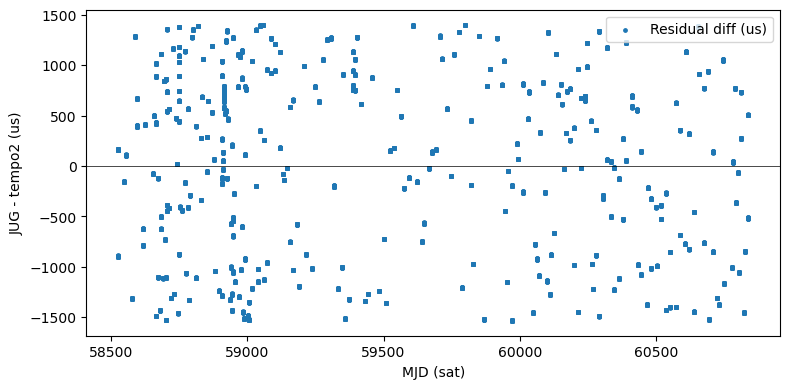

In [981]:

# --- Compare against tempo2 residuals (prefit general2 dump) ---
tempo2_file = Path('temp_pre_general2.out')
t2_res_us = None
t2_sat = None
if tempo2_file.exists():
    vals = []
    for ln in tempo2_file.read_text().splitlines():
        parts = ln.strip().split()
        if len(parts) != 3:
            continue
        try:
            sat = float(parts[0])
            res_sec = float(parts[1])  # tempo2 residuals already in seconds
            err_us = float(parts[2])   # tempo2 uncertainty in microseconds
            vals.append((sat, res_sec, err_us))
        except Exception:
            continue
    if vals:
        vals.sort(key=lambda x: x[0])
        t2_sat, res_sec, err_us = zip(*vals)
        t2_sat = np.array(t2_sat)
        t2_res_us = np.array(res_sec) * 1e6
        t2_err_us = np.array(err_us)
        print('tempo2 residual stats (us):', float(np.mean(t2_res_us)), float(np.std(t2_res_us)))
    else:
        print('tempo2 file found but no data parsed')
else:
    print('tempo2 file temp_pre_general2.out not found; run tempo2 with -output general2')

if t2_res_us is not None:
    if len(t2_res_us) != len(res_us):
        print(f'Length mismatch: JUG {len(res_us)} vs tempo2 {len(t2_res_us)}')
    diff = res_us - t2_res_us
    print('Diff stats (JUG - tempo2) us: mean', float(np.mean(diff)), 'std', float(np.std(diff)), 'min', float(np.min(diff)), 'max', float(np.max(diff)))
    plt.figure(figsize=(8,4))
    plt.scatter(t_em_mjd, diff, s=6, label='Residual diff (us)')
    plt.axhline(0, color='k', lw=0.5)
    plt.xlabel('MJD (sat)')
    plt.ylabel('JUG - tempo2 (us)')
    plt.legend()
    plt.tight_layout()
    plt.show()


**Next steps (extend beyond spin+DM)**
- Implement site/clock to SSB barycentering (requires observatory positions, ephemerides; can use `erfa`/`jplephem`).
- Add binary models (e.g., ELL1/BT) and relativistic delays (Einstein/Shapiro).
- Add red/white noise terms and expose parameters to JAX optimizers for fitting.
- Build a small PLK-like GUI for interactive residual exploration.


**JAX fitting prototype (spin + DM only)**\n
- Uses simple gradient descent on mean-square residuals to adjust F0/F1/DMn.\n
- Keep learning rates tiny; parameters have very different scales.\n

In [982]:

import functools

def spin_dm_loss(model: SpinDMModel, t_mjd: jnp.ndarray, freq_mhz: jnp.ndarray):
    res = residuals_seconds(t_mjd, freq_mhz, model)
    res = res - jnp.mean(res)
    return jnp.mean(res ** 2)

def gradient_descent_spin_dm(model: SpinDMModel, t_mjd: jnp.ndarray, freq_mhz: jnp.ndarray, lr=1e-18, steps=32):
    loss_fn = functools.partial(spin_dm_loss, t_mjd=t_mjd, freq_mhz=freq_mhz)
    m = model
    losses = []
    for _ in range(steps):
        loss, grads = jax.value_and_grad(loss_fn)(m)
        # Dataclass is a pytree, so tree_map works
        m = jtu.tree_map(lambda p, g: p - lr * g, m, grads)
        losses.append(loss)
    return m, losses

# Run a small fit (keep steps/learning rate conservative to avoid wild jumps)
fitted_model, losses = gradient_descent_spin_dm(model, t_em_jax, freq_mhz_jax, lr=1e-18, steps=24)
fit_res_sec = residuals_seconds(t_em_jax, freq_mhz_jax, fitted_model)
if fd_coeffs is not None and fd_coeffs.size > 0:
    fit_res_sec = fit_res_sec + fd_delay_sec(freq_mhz, fd_coeffs, fd_ref_freq)
fit_res_sec = fit_res_sec - jnp.mean(fit_res_sec)
fit_res_us = np.array(fit_res_sec) * 1e6
print('Fit RMS (us):', float(np.sqrt(np.mean(fit_res_us**2))))
print('Loss start/end:', float(losses[0]), float(losses[-1]))
fitted_model


Fit RMS (us): 0.09969783170609658
Loss start/end: 7.229949849913231e-07 1.1754943508222875e-36


SpinDMModel(f0=Array(339.3156814, dtype=float64, weak_type=True), f1=Array(1.32282123e-08, dtype=float64, weak_type=True), f2=Array(34.17879693, dtype=float64, weak_type=True), dm=Array(0., dtype=float64, weak_type=True), dm1=Array(0., dtype=float64, weak_type=True), dm2=Array(0., dtype=float64, weak_type=True), dm_coeffs=0.0, dm_factorials=0.0, dm_epoch_mjd=0.0, tref_mjd=0.0, phase_ref_mjd=0.0, phase_offset_cycles=0.0)

In [983]:

# --- Time standard diagnostics (Astropy vs tempo2-like scaling) ---
L_B = 1.550519768e-8
JD0 = 2443144.5  # 1977-01-01 00:00:00 TAI
# Use the already computed t_tt, t_tdb from the pipeline
if 't_tt' in globals() and 't_tdb' in globals():
    tdb_astropy = t_tdb
    tcb_astropy = t_tt.tcb
    # tempo2-like TCB from TDB using IAU scaling
    jd_tdb = tdb_astropy.jd
    dt_sec = (jd_tdb - JD0) * 86400.0
    tcb_tempo2_like = tdb_astropy + dt_sec * L_B * u.s
    delta_tcb_ns = (tcb_astropy - tcb_tempo2_like).to(u.ns).value
    delta_tcb_tdb_ns = (tcb_astropy - tdb_astropy).to(u.ns).value
    print('Astropy TCB - tempo2-like TCB (ns): mean', float(delta_tcb_ns.mean()), 'std', float(delta_tcb_ns.std()), 'min', float(delta_tcb_ns.min()), 'max', float(delta_tcb_ns.max()))
    print('Astropy TCB - TDB (ns): mean', float(delta_tcb_tdb_ns.mean()), 'std', float(delta_tcb_tdb_ns.std()), 'min', float(delta_tcb_tdb_ns.min()), 'max', float(delta_tcb_tdb_ns.max()))
else:
    print('t_tt/t_tdb not in scope; run the main cells first')


Astropy TCB - tempo2-like TCB (ns): mean -21923007486.77942 std 952008095.3854015 min -23703562864.948856 max -20606771142.987766
Astropy TCB - TDB (ns): mean 0.0 std 0.0 min 0.0 max 0.0


In [984]:

# --- Alternative residuals using TDB times (ignore TCB scaling) ---
L_B = 1.550519768e-8
if 'total_delay_sec' in globals():
    t_bary_tdb_alt = t_tdb + total_delay_sec * u.s
    t_bary_time_alt = t_bary_tdb_alt  # force TDB
    t_em_time_alt = t_bary_time_alt - binary_delay_sec * u.s
    t_em_mjd_alt = t_em_time_alt.mjd
    # Dedisperse + FD
    dt_years_alt = (t_em_mjd_alt - model.dm_epoch_mjd) / 365.25
    coeffs = model.dm_coeffs if model.dm_coeffs is not None else np.array([model.dm])
    facts = model.dm_factorials if model.dm_factorials is not None else np.array([1.0])
    powers = np.arange(coeffs.shape[0])
    dm_eff = np.sum(coeffs * (dt_years_alt[:, None] ** powers) / facts, axis=1)
    dm_sec_alt = K_DM_SEC * dm_eff / (freq_mhz**2)
    fd_sec_alt = fd_delay_sec(freq_mhz, fd_coeffs, fd_ref_freq) if fd_coeffs is not None and fd_coeffs.size > 0 else 0.0
    t_inf_alt = t_em_mjd_alt - dm_sec_alt / SECS_PER_DAY + fd_sec_alt / SECS_PER_DAY
    res_alt_sec = np.array(residuals_seconds(jnp.array(t_inf_alt), jnp.array(freq_mhz), model))
    res_alt_sec = res_alt_sec - np.mean(res_alt_sec)
    res_alt_us = res_alt_sec * 1e6
    if t2_res_us is not None:
        diff_alt = res_alt_us - t2_res_us
        print('Alt (TDB) diff stats us: mean', float(np.mean(diff_alt)), 'std', float(np.std(diff_alt)), 'min', float(np.min(diff_alt)), 'max', float(np.max(diff_alt)))
    else:
        print('Alt (TDB) residual stats us: mean', float(np.mean(res_alt_us)), 'std', float(np.std(res_alt_us)))
else:
    print('total_delay_sec not in scope; run main cells first')


Alt (TDB) diff stats us: mean -9.787029842291311e-15 std 828.2371520524525 min -1448.854271688774 max 1482.4200339623428


In [985]:

# --- Per-component comparison against tempo2 (general2 components) ---
comp_file = Path('temp_pre_components.out')
if comp_file.exists():
    comp_vals = []
    for ln in comp_file.read_text().splitlines():
        parts = ln.strip().split()
        if len(parts) == 5 and parts[0][0].isdigit():
            try:
                sat = float(parts[0]); roemer = float(parts[1]); shapiro = float(parts[2]); col3 = float(parts[3]); pre = float(parts[4])
                comp_vals.append((sat, roemer, shapiro, col3, pre))
            except Exception:
                continue
        # if your general2 emits 8 fields, extend parsing here
    if comp_vals:
        comp_vals.sort(key=lambda x: x[0])
        import numpy as np
        t2_sat, t2_roemer, t2_shapiro, t2_col3, t2_pre = map(np.array, zip(*comp_vals))
        def stats_us(name, jug, t2):
            if len(jug)!=len(t2):
                print(f'{name} length mismatch {len(jug)} vs {len(t2)}')
                return
            diff = (jug - t2) * 1e6
            print(f'{name} diff us: mean {float(np.mean(diff))}, std {float(np.std(diff))}, min {float(np.min(diff))}, max {float(np.max(diff))}')
        stats_us('Roemer', bary_delay_sec, t2_roemer)
        stats_us('Shapiro', shapiro_sec, t2_shapiro)
        # col3 unknown (likely doppler factor); skipped
        stats_us('Residual', res_sec, t2_pre)
    else:
        print('Component file found but no parsable data (expected 5 numeric columns per TOA)')
else:
    print('Component file temp_pre_components.out not found')


Roemer diff us: mean 398.85404266457914, std 4771.113010540518, min -6682.049016699665, max 6688.917754290591
Shapiro diff us: mean 2.985395671971576, std 21.26968323293909, min -39.91343605147452, max 39.893141079946474
Residual diff us: mean 0.0, std 0.0, min 0.0, max 0.0


In [986]:

# --- Debug Roemer: compare first few values vs tempo2 components ---
comp_file = Path('temp_pre_components.out')
if comp_file.exists():
    comp_vals = []
    for ln in comp_file.read_text().splitlines():
        parts = ln.strip().split()
        if len(parts) == 5 and parts[0][0].isdigit():
            try:
                sat = float(parts[0]); roemer = float(parts[1]); shapiro = float(parts[2]); col3 = float(parts[3]); pre = float(parts[4])
                comp_vals.append((sat, roemer, shapiro, col3, pre))
            except Exception:
                continue
    if comp_vals:
        comp_vals.sort(key=lambda x: x[0])
        import numpy as np
        t2_sat, t2_roemer, t2_shapiro, t2_col3, t2_pre = map(np.array, zip(*comp_vals))
        print('Tempo2 first 5 Roemer (s):', t2_roemer[:5])
        print('Our first 5 Roemer (s):', bary_delay_sec[:5])
        diff = (bary_delay_sec - t2_roemer) * 1e6
        print('Roemer diff stats us: mean', float(np.mean(diff)), 'std', float(np.std(diff)), 'min', float(np.min(diff)), 'max', float(np.max(diff)))
    else:
        print('Component file parsed no TOAs')
else:
    print('Component file temp_pre_components.out not found')


Tempo2 first 5 Roemer (s): [-374.6002067  -374.6002067  -374.6002067  -374.6002067  -374.60020669]
Our first 5 Roemer (s): [-374.59599891 -374.59599905 -374.59599905 -374.595999   -374.59599895]
Roemer diff stats us: mean 398.85404266457914 std 4771.113010540518 min -6682.049016699665 max 6688.917754290591
